# Customer Churn Prediction with IBM Db2 using PySpark

# Part 2 : Mixed learning

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a PySpark kernel. It is the second part of a series on this use case. It is focused on building and evaluating machine learning models. The goal is to build the model with the higher recall on our test set. Visualizations are plotted locally using matplotlib whereas models are built using PySpark and is loaded from IBM Db2.

__Use case__

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity of preventing a customer from ending her contract (false negative). We also care to accurately target customers with engagement campaigns : not overwhelming customers with commercials and not losing money by proposing special offers to too many people (accuracy). Our optimization objective will thus consist in maximizing recall id est minimizing the false negative rate. We will also look at a couple of other indicators such as accuracy and area under curve.

__Data exploration and preparation__

In the previous notebook, we used PySpark for data exploration and visualization. We created, scaled and selected features. 


__Contents__
1. Get ready
2. Build customer clusters with KMeans
3. Compare model performances on the train set
4. Tune hyperparameters on the validation set
5. Assess your model performances on the test set

## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [22]:
# Useful imports - PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql import Row

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   246.5|      108|     41.91|   216.3|       89|     18.39|     179.6|         99|        8.08|     12.7|         3|       3.43|        2|
|    1| 408|    1|         0|   298.1|      112|     50.68|   201.3|      100|     17.11|     214.7|         88|        9.66|      9.7|         4|       2.62|        2|
|    0| 510|    1|         0|   119.3|       82|     20.28|   185.1|      111|     15.73|     157.0|         74|        7.07|     10.9|         4|       2.

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced.

In [4]:
train, val, test = df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Build customer clusters with KMeans

First, let's see if we can identify some customer clusters with KMeans unsupervised algorithm. We will enrich our current dataset with information from clustering.

### a. Apply unsupervised learning for customer segmentation with kMeans

__Create a model__ 

Build a Spark ML algorithm that selects the call counts from the customer data and clusters them using KMeans.

In [5]:
# We choose to keep the 12 most relevant features

assembler_12 = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE"],
    outputCol="features")

# clusters will be built on training data only
train_12 = assembler_12.transform(train)

# Set characteristics of your model 
kmeans = KMeans().setK(15).setSeed(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fit the model to the required training set and run the algorithm to find the clusters.

In [6]:
model = kmeans.fit(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
cluster_predictions = model.transform(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Inference__

KMeans is an unsupervized learning algorithm: we have to see if the clusters we have just built can be really be used to infer churn!

In [8]:
# Number of customers in each cluster
cluster_predictions.groupBy("prediction").count().sort("count").withColumnRenamed("prediction", "ClusterID").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|ClusterID|count|
+---------+-----+
|       13|  101|
|        5|  101|
|        9|  120|
|        2|  122|
|        8|  133|
|       14|  139|
|       10|  147|
|        7|  155|
|        1|  163|
|        6|  163|
|        4|  164|
|        0|  165|
|       11|  189|
|       12|  212|
|        3|  247|
+---------+-----+

__Silhouette score__

The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from −1 to +1. The closer to 1, the better: the object is then well matched to its own cluster and differs from the points belonging to neighboring clusters. If most objects have a high value, then the clustering configuration is considered to be appropriate. Otherwise there may be too many or too few clusters. Here we compute a mean value over all points, using the Euclidean distance.

In [9]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(cluster_predictions)
print("Silhouette with squared euclidean distance = %.3f " % silhouette)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.305

The choice of k=15 allows to target well our customers: churn propencies range from `4.9% to 57%`. With less clusters, we obtain a higher Silhouette score but average churn percentages are less differentiated. We cannot increase the number of clusters too much if we do not have more data, because the model becomes more sensible to outliers. 

In [10]:
# Churn proportion in each cluster
churn_proportion = cluster_predictions.groupBy("prediction").avg("CHURN").sort("avg(CHURN)").withColumnRenamed("prediction", "ClusterID")
churn_proportion.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|ClusterID|          avg(CHURN)|
+---------+--------------------+
|        1|0.049079754601226995|
|        3| 0.06882591093117409|
|       10| 0.07482993197278912|
|        7| 0.07741935483870968|
|       14| 0.07913669064748201|
|        5|  0.0891089108910891|
|        6| 0.09815950920245399|
|       11| 0.10052910052910052|
|        4| 0.10365853658536585|
|        8| 0.11278195488721804|
|        2| 0.13934426229508196|
|       12| 0.14150943396226415|
|        0| 0.14545454545454545|
|       13|  0.5445544554455446|
|        9|  0.5666666666666667|
+---------+--------------------+

Next, we will use the avg(CHURN) column as a new feature.

### b. Use avg(CHURN) as an additional feature

In [11]:
# Extract ClusterIDs and churn percentages for each cluster
churn_proportion_list = list(churn_proportion.select("avg(CHURN)").toPandas()["avg(CHURN)"])

ClusterID_list = list(churn_proportion.select("ClusterID").toPandas()["ClusterID"])

# Transform into a dictionary:
dico = {}
for i in range(len(ClusterID_list)):
    dico[ClusterID_list[i]] = churn_proportion_list[i]
print(dico)    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{1: 0.049079754601226995, 3: 0.06882591093117409, 10: 0.07482993197278912, 7: 0.07741935483870968, 14: 0.07913669064748201, 5: 0.0891089108910891, 6: 0.09815950920245399, 11: 0.10052910052910052, 4: 0.10365853658536585, 8: 0.11278195488721804, 2: 0.13934426229508196, 12: 0.14150943396226415, 0: 0.14545454545454545, 13: 0.5445544554455446, 9: 0.5666666666666667}

In [12]:
def preparation(DF):
    """
    Inputs : DF is a raw dataframe 
    Outputs : dataframe with additional colmns : features for Clustering, 
    Cluster prediction and corresponding cluster churn percentage
    """

    # We choose to keep only 6 features here (leads to higher cluster separation)
    #assembler_6 = VectorAssembler(inputCols=["TOT_MINS", "VMAIL", "INTL_CALLS", "DAY_CALLS", "SVC_CALLS", "DAY_CHARGE"], outputCol="features")

    # assemble 
    DF_12 = assembler_12.transform(DF)
    
    # Assign each point of the training set to its cluster
    DF_with_clusterIDs = model.transform(DF_12)

    # Create a new dataframe corresponding to the churn percentages for each point
    avgChurn = DF_with_clusterIDs.rdd.map(lambda element : dico[element.prediction])
    row = Row("prediction") 
    avgChurn_df = avgChurn.map(row).toDF().withColumnRenamed("prediction", "ClusterChurn")
    
    # Join tables
    temp1 = avgChurn_df.toPandas()
    temp2 = DF_with_clusterIDs.toPandas()
    temp2["ClusterChurn"] = temp1["ClusterChurn"]
    DF_with_avg = spark.createDataFrame(temp2)
    
    DF_with_avg_renamed = DF_with_avg.withColumnRenamed("features", "featuresClustering").withColumnRenamed("prediction", "predictionClustering")
    print(DF_with_avg_renamed.count())
    
    return DF_with_avg_renamed

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
prepared_train = preparation(train)
prepared_val = preparation(val)
prepared_test = preparation(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2321
495
517

## 3. Compare model performances on the train set

In this section, we will train logistic regression, random forest and gradient boosted trees on the train set. We will compare the performance of the resulting models on the train set. 

__Prepare the data__

Select columns and set label names for training. Here we choose to reuse the 6 column selected above. You can test other options if you like.

In [14]:
# Define the assembler
assembler_12 = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"],
    outputCol="features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Transform your training set
assembled_train = assembler_12.transform(prepared_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Select only the label and features columns
labeled_train = assembled_train.select(assembled_train["features"], assembled_train["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Build models__

In [17]:
### Logistic regression ###

# Define your model
lr = LogisticRegression(maxIter = 100)
# Fit the model
lrModel = lr.fit(labeled_train)
# Make predictions
pred_train_lr = lrModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
### Random Forest ###

# Define your model
rf = RandomForestClassifier()
# Fit the model
rfModel = rf.fit(labeled_train)
# Make predictions
pred_train_rf = rfModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
### Gradient Boosted Trees ###

# Define your model
gbt = GBTClassifier()
# Fit the model
gbtModel = gbt.fit(labeled_train)
# Make predictions
pred_train_gbt = gbtModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As you may just have witnessed, GBT takes more time than the other two algorithms.

__Area under Curve__

In [27]:
# Define the evaluators
binEval_AUROC = BinaryClassificationEvaluator().setMetricName("areaUnderROC").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval_AUPRC = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")

pred = [pred_train_lr, pred_train_rf, pred_train_gbt]
algo = ["Logistic Regression", "Random Forest", "Gradient Boosted Trees"]

# Print results
for i in range(len(pred)):
    print(algo[i])
    print("Area under ROC: %.3f" % binEval_AUROC.evaluate(pred[i]))
    print("Area under PR curve: %.3f" % binEval_AUPRC.evaluate(pred[i]))
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression
Area under ROC: 0.808
Area under PR curve: 0.498

Random Forest
Area under ROC: 0.905
Area under PR curve: 0.797

Gradient Boosted Trees
Area under ROC: 0.948
Area under PR curve: 0.887

On the training set, GBT seems to perform better. Let's have a look at other metrics.

__Metrics and confusion matrix__

* Confusion matrix 

<img src="confusionMatrix.png" width=800/>

Sensitivity = TP / (TP + FN), also called Recall

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

Negative Predictive Value = TN / (TN + FN)

F1-score: 2 x Precision x Recall / (Precision + Recall)

Recall = 1 - FNR. 

In [30]:
# Metrics (1/2)

# Define evaluators
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_wp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# Print results

pred = [pred_train_lr, pred_train_rf, pred_train_gbt]
algo = ["__Logistic Regression__", "__Random Forest__", "__Gradient Boosted Trees__"]

# Print results
for i in range(len(pred)):
    print(algo[i])
    wp = evaluator_wp.evaluate(pred[i])
    accuracy = evaluator_acc.evaluate(pred[i])
    f1 = evaluator_f1.evaluate(pred[i])
    print("Accuracy = %.3f" % accuracy)
    print("f1 = %.3f" % f1)
    print("weightedPrecision = %.3f" % wp)
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression
Accuracy = 0.877
f1 = 0.858
weightedPrecision = 0.858

Random Forest
Accuracy = 0.938
f1 = 0.931
weightedPrecision = 0.939

Gradient Boosted Trees
Accuracy = 0.954
f1 = 0.951
weightedPrecision = 0.955

In [31]:
# Metrics (2/2)

def confusion_matrix(pred_DF):
    """
    Input : 
    pred_DF : Saprk DataFrame obtained after a model.transform() transformation
    Output :
    (tn, fp, fn, tp) tuple of integers
    """
    
    # as pandas DF
    label = pred_DF.toPandas()["label"]
    prediction = pred_DF.toPandas()["prediction"]
    
    # true = tp + tn
    true = sum(label)

    # tp : sum(if pred = label = 1) or count(pred+label=2)
    tp = sum(label+prediction==2)
    
    # fn = total number of positive - predicted positives which are rightly predicted
    fn = true - tp

    # tn : sum(if pred=label=0) or count(pred+label=0)
    tn = sum(label+prediction==0)

    # fp = total number of negative - tn
    fp = len(label) - true - tn
    
    return (tn, fp, fn, tp)


def FNR(fn, tp):
    return fn/(fn+tp)

def recall(tp, fn):
    # also called TPR or sensitivity
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Print results
for i in range(len(pred)):
    print(algo[i])
    # Confusion matrix
    (tn, fp, fn, tp)=confusion_matrix(pred[i])
    # Confusion matrix in format [[tp, fn], [fp, tn]]
    print("Confusion matrix: ")
    print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))
    # Metrics
    print("FNR: %.3f" % FNR(fn, tp))
    print("Recall: %.3f" % recall(tp, fn))
    print("Precision: %.3f" % precision(tp, fp))
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression
Confusion matrix: 
[['tp: 100' 'fn: 229']
 ['fp: 56' 'tn: 1936']]
FNR: 0.696
Recall: 0.304
Precision: 0.641

Random Forest
Confusion matrix: 
[['tp: 191' 'fn: 138']
 ['fp: 7' 'tn: 1985']]
FNR: 0.419
Recall: 0.581
Precision: 0.965

Gradient Boosted Trees
Confusion matrix: 
[['tp: 228' 'fn: 101']
 ['fp: 6' 'tn: 1986']]
FNR: 0.307
Recall: 0.693
Precision: 0.974

Again, GBT seems to perform better when we just use the default hyperparameters. Let's see if this is still is the case on the validation set.

## 4. Fine tune your hyperparameters on the validation set

In the following cell, default values are used for logistic regression's parameters. 

In [34]:
# Transform your validation set
assembled_val = assembler_12.transform(prepared_val)

# Select only the label and features columns
labeled_val = assembled_val.select(assembled_val["features"], assembled_val["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Grid search__ 

In the next cell we define a function to test a range of hyperparameters for regularization in order to minimize the False Negative Rate (FNR).

Which hyperparameters do we tune ? Let's have a look at what is available. We highlighted the hyperparameters chosen here.

* Logistic Regression

> class pyspark.ml.classification.LogisticRegression(self, featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100, `regParam=0.1`, `elasticNetParam=0.0`, tol=1e-6, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol="probability", rawPredictionCol="rawPrediction", standardization=True, weightCol=None)

* Random Forest

> class pyspark.ml.classification.RandomForestClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", probabilityCol="probability", rawPredictionCol="rawPrediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity="gini", `numTrees=20`, featureSubsetStrategy="auto", seed=None, subsamplingRate=1.0)

* GBT

> GBTClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="logistic", maxIter=20, `stepSize=0.1`, seed=None, subsamplingRate=1.0)
                 
 Note : for more details on each hyperparameter, use .explainParams(). For example :
 >  gbt.explainParams()

In [43]:
def grid_search_lr():
    """
    Output:
    best: dictionary with best hyperparameters and corresponding metrics
    """
       
    # Hyperparameter ranges
    regParam_range=[0, 0.001, 0.002, 0.005, 0.01]
    elasticNetParam_range=[0, 0.001, 0.002, 0.005, 0.01]
    
    best={"regParam":0, "elasticNetParam": 0, "val_recall": 0}
          
    for r in regParam_range:
        for e in elasticNetParam_range:
           
            # Define your model
            logReg = LogisticRegression(maxIter=100, regParam=r, elasticNetParam=e)

            # Fit the model on training set
            logRegModel = logReg.fit(labeled_train)

            # Make predictions
            pred_val = logRegModel.transform(labeled_val)
            
            # Compute the confusion matrix and FNR for both sets
            (tn, fp, fn, tp) = confusion_matrix(pred_val)
            val_recall = recall(tp, fn)
            
            if val_recall >= best["val_recall"]: # to have more regularization for equal performance
                best["regParam"] = r
                best["elasticNetParam"] = e
                best["val_recall"] = val_recall
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
def grid_search_rf():
    """
    Input:
    DF : Spark Dataframe, prepared with features and label columns
    
    Output:
    best: dictionary with best hyperparameters and corresponding metrics
    """
       
    # Hyperparameter ranges
    maxDepth=[5, 10]
    maxBins=[32, 64]
    numTrees=[15, 20, 25]
    
    best={"maxDepth": 5, "maxBins": 32, "numTrees": 20, "val_recall": 0}
          
    for D in maxDepth:
        for B in maxBins:
            for T in numTrees : 

                # Define your model
                rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

                # Fit the model on training set
                rfModel = rf.fit(labeled_train)

                # Make predictions
                pred_val = rfModel.transform(labeled_val)

                # Compute the confusion matrix and FNR for both sets
                (tn, fp, fn, tp) = confusion_matrix(pred_val)
                val_recall = recall(tp, fn)
                
                #print("Validation FNR = " +str(val_FNR))
                #print("")

                if val_recall >= best["val_recall"]: # to have more regularization for equal performance
                    best["maxDepth"] = D
                    best["maxBins"] = B
                    best["numTrees"] = T
                    best["val_recall"] = val_recall
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
def grid_search_gbt():
    """
    Input:
    DF : Spark Dataframe, prepared with features and label columns
    
    Output:
    best: dictionary with best hyperparameters and corresponding metrics
    """
       
    # Hyperparameter ranges
    maxDepth=[5, 10, 20]
    maxBins=[16, 32, 64]
    stepSize=[0.05, 0.1]
    
    best={"maxDepth": 0, "maxBins":0, "stepSize":0, "val_recall": 0}
          
    for D in maxDepth:
        for B in maxBins:
            for s in stepSize : 

                # Define your model
                gbt = GBTClassifier(maxDepth=D, maxBins=B, stepSize=s)

                # Fit the model on training set
                gbtModel = gbt.fit(labeled_train)

                # Make predictions
                pred_val = gbtModel.transform(labeled_val)

                # Compute the confusion matrix and FNR for both sets
                (tn, fp, fn, tp) = confusion_matrix(pred_val)
                val_recall = recall(tp, fn)
                
                #print("Validation FNR = " +str(val_FNR))
                #print("")

                if val_recall >= best["val_recall"]: # to have more regularization for equal performance
                    best["maxDepth"] = D
                    best["maxBins"] = B
                    best["stepSize"] = s
                    best["val_recall"] = val_recall
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

If you want to save some time, here are the results :

In [46]:
best_lr = {'regParam': 0.002, 'elasticNetParam': 0.001, 'val_recall': 0.24390243902439024}
best_rf = {'maxDepth': 10, 'maxBins': 64, 'numTrees': 25, 'val_recall': 0.524390243902439}
best_gbt = {'maxDepth': 5, 'maxBins': 32, 'stepSize': 0.1, 'val_recall': 0.5853658536585366}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
# If you want to save some time, don't run this cell! 

best_lr = grid_search_lr()
print(best_lr)

best_rf = grid_search_rf()
print(best_rf)

best_gbt = grid_search_gbt()
print(best_gbt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'regParam': 0.002, 'elasticNetParam': 0.001, 'val_recall': 0.24390243902439024}
{'maxDepth': 10, 'maxBins': 64, 'numTrees': 25, 'val_recall': 0.524390243902439}
{'maxDepth': 5, 'maxBins': 32, 'stepSize': 0.1, 'val_recall': 0.5853658536585366}

__Visualize feature importance__

In [48]:
# Define your model
logReg = LogisticRegression(maxIter=100, regParam=best_lr["regParam"], elasticNetParam=best_lr["elasticNetParam"])

# Fit the model on training set
logRegModel = logReg.fit(labeled_train)


# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(logRegModel.coefficients))
print("Intercept: " + str(logRegModel.intercept))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [0.49352483261577956,0.0017602656730128982,0.010375408969149938,-0.020914146734751095,0.11478149126217094,-0.11087092767952629,0.18821456401255657,0.05061760532752884,0.020146778473970645,0.0017118523015505517,0.0008795076483460946,0.019550788820730722,5.128412728136836]
Intercept: -5.849715742627431

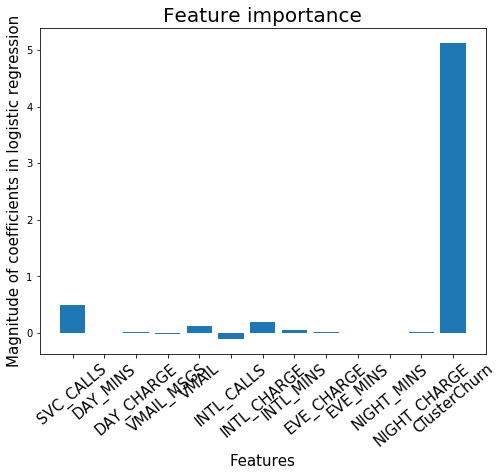

In [49]:
%local

#copy paste new coeffs list if necessary

features=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]

coeffs=[0.49352483261577956,0.0017602656730128982,0.010375408969149938,-0.020914146734751095,0.11478149126217094,-0.11087092767952629,0.18821456401255657,0.05061760532752884,0.020146778473970645,0.0017118523015505517,0.0008795076483460946,0.019550788820730722,5.128412728136836]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients in logistic regression', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance', fontsize=20)
plt.show()

Note : features were not scaled here so the visualization seems to give an overwhelming weight to ClusterChurn, which it does not have in reality.

In [51]:
# Define your model
rf = RandomForestClassifier(maxDepth = best_rf["maxDepth"], maxBins = best_rf["maxBins"], numTrees = best_rf["numTrees"])

# Fit the model on training set
rfModel = rf.fit(labeled_train)

print(rfModel.featureImportances)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.18178811184798255,0.16012024813703055,0.0838730648127356,0.04829091633062102,0.038785791711073075,0.03954393003297476,0.04112787441993293,0.045218720519418075,0.08050873268287183,0.06845799924702964,0.03970568743887793,0.037886804314506035,0.1346921185049461])

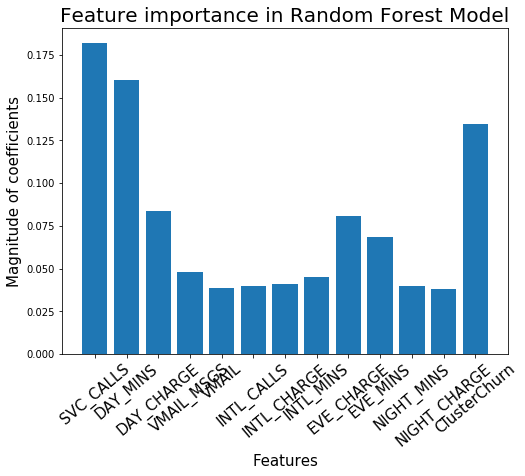

In [52]:
%local

import matplotlib.pyplot as plt
import numpy as np

features = ["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]
coeffs = [0.18178811184798255,0.16012024813703055,0.0838730648127356,0.04829091633062102,0.038785791711073075,0.03954393003297476,0.04112787441993293,0.045218720519418075,0.08050873268287183,0.06845799924702964,0.03970568743887793,0.037886804314506035,0.1346921185049461]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance in Random Forest Model', fontsize=20)
plt.show()

In [55]:
# Define your model
gbt = GBTClassifier(maxDepth=best_gbt["maxDepth"], maxBins=best_gbt["maxBins"], stepSize=best_gbt["stepSize"])
                    
# Fit the model on training set
gbtModel = gbt.fit(labeled_train)

print(gbtModel.featureImportances)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13,[0,1,3,4,5,6,8,9,10,11,12],[0.08604907727746372,0.17990409496699397,0.062380698472049766,0.040737334334920466,0.09673148702932027,0.11831440107351968,0.13769400258490144,0.04801852764059272,0.09398745422993804,0.017899850163581348,0.11828307222671867])

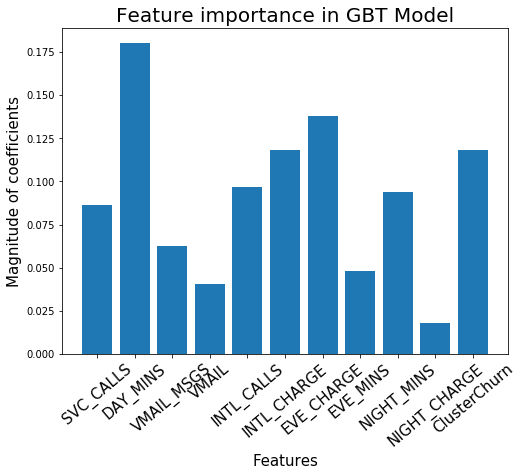

In [56]:
%local

features = ["SVC_CALLS", "DAY_MINS", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]
coeffs = [0.08604907727746372,0.17990409496699397,0.062380698472049766,0.040737334334920466,0.09673148702932027,0.11831440107351968,0.13769400258490144,0.04801852764059272,0.09398745422993804,0.017899850163581348,0.11828307222671867]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance in GBT Model', fontsize=20)
plt.show()

Differs qualitatively and quantitatively from the previous model! GBT does not use all features, in contrast to random forest.

## 5. Assess your model performance on the test set

See what is the final perfomance of your tuned model on unseen data.

In [58]:
# Prepare the test set
assembled_test = assembler_12.transform(prepared_test)

# Select only the label and features columns
labeled_test = assembled_test.select(assembled_test["features"], assembled_test["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Logistic regression__

In [63]:
# Make predictions on test set
pred_test_lr = logRegModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy: %.3f" %  evaluator_acc.evaluate(pred_test_lr))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_lr)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# FNR
print("Recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.880
Confusion matrix: 
[['tp: 22' 'fn: 50']
 ['fp: 12' 'tn: 433']]
Recall: 0.306

__Random Forest__

In [65]:
# Make predictions on test set
pred_test_rf = rfModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator_acc.evaluate(pred_test_rf))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Recall
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.925
Confusion matrix: 
[['tp: 41' 'fn: 31']
 ['fp: 8' 'tn: 437']]
recall: 0.569

__GBT__

In [66]:
# Make predictions on test set
pred_test_gbt = gbtModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator_acc.evaluate(pred_test_gbt))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_gbt)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Recall
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.919
Confusion matrix: 
[['tp: 41' 'fn: 31']
 ['fp: 11' 'tn: 434']]
recall: 0.569

__Model choice__ 

* Logistic regression 

It does clearly not perform as well as the ensemble models. 

Comparison between Random Forest and GBT :

* Random Forest 

Model : {'maxDepth': 10, 'maxBins': 64, 'numTrees': 25, 'val_recall': 0.524390243902439}

Confusion matrix on test set : [['tp: 41' 'fn: 31'], ['fp: 8' 'tn: 437']]

Recall on test set : 0.569

Test Accuracy = 0.925

Hyperparameter tuning took only a few seconds.

* GBT

Model : {'maxDepth': 5, 'maxBins': 32, 'stepSize': 0.1, 'val_recall': 0.5853658536585366}

Confusion matrix on test set : [['tp: 41' 'fn: 31'], ['fp: 11' 'tn: 434']]

Recall on test set : 0.569

Test Accuracy = 0.919

Hyperparameter tuning took approximately 6 minutes.

__=> We shall keep the Random Forest model because it has a high recall and the best accuracy.__

__Gain graph__

In [67]:
pred_test_rf.createOrReplaceTempView("pred_test")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
%%sql -o pred_test --maxrows -1
SELECT * FROM pred_test

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [71]:
%local

# Extract the relevant data

# Predicted proba that label is 1
proba0 = [x["values"][0] for x in pred_test["probability"]]
# equivalent to 
# proba1 = pred_test.select("probability").toPandas().values.tolist()

pred_test["proba0"] = pd.Series(proba0)
sorted_pred_test = pred_test.sort_values(by="proba0").drop(["features", "rawPrediction", "probability"], axis=1)

sorted_pred_test.head(5)

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [74]:
%local

# Reset index
sorted_pred_test_bis = sorted_pred_test.reset_index(drop=True)
n = len(sorted_pred_test_bis)

# Add cumulated count for #customers and cumulated frequency for %churners

#Initialize columns
sorted_pred_test_bis["#Customers"] = pd.Series([0 for x in range(n)])
sorted_pred_test_bis["#predChurners"] = pd.Series([0 for x in range(n)])
sorted_pred_test_bis["#trueChurners"] = pd.Series([0 for x in range(n)])

# case i = 0
sorted_pred_test_bis["#Customers"][0] = 1
sorted_pred_test_bis["#predChurners"][0] = sorted_pred_test_bis["prediction"][0]
sorted_pred_test_bis["#trueChurners"][0] = sorted_pred_test_bis["label"][0]

# case i>0
for i in range(1,n):
    sorted_pred_test_bis["#Customers"][i] = i+1
    sorted_pred_test_bis["#predChurners"][i] = sorted_pred_test_bis["#predChurners"][i-1] + sorted_pred_test_bis["prediction"][i]
    sorted_pred_test_bis["#trueChurners"][i] = sorted_pred_test_bis["#trueChurners"][i-1] + sorted_pred_test_bis["label"][i]

m = sum(sorted_pred_test_bis["label"])
sorted_pred_test_bis["#predChurners"]/= m  
sorted_pred_test_bis["#trueChurners"]/= m

sorted_pred_test_bis

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/eva.feillet/

Output()

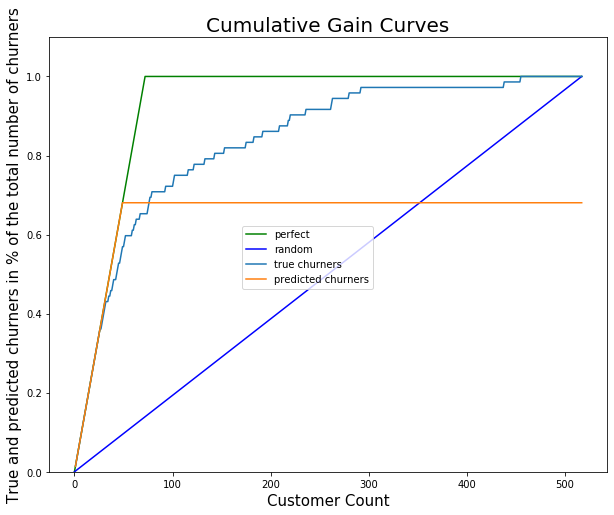

In [78]:
%local

ax, fig=plt.subplots(figsize=(10,8))
    
x_random = [0,n]
y_random = [0,1]

x_perfect = [0,m,n]
y_perfect = [0,1,1]

plt.ylim((0, 1.1)) 

plt.plot(x_perfect, y_perfect, color = 'g', label = "perfect")
plt.plot(x_random, y_random, color = 'b', label = "random")

x = sorted_pred_test_bis["#Customers"].values.tolist()
y = [sorted_pred_test_bis["#trueChurners"].values.tolist(), sorted_pred_test_bis["#predChurners"].values.tolist()]
labels = ["true churners", "predicted churners"]

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.xlabel('Customer Count', fontsize=15)
plt.ylabel('True and predicted churners in % of the total number of churners', fontsize=15)
ax.legend(loc='center')
plt.title('Cumulative Gain Curves', fontsize=20)

plt.show()    

## What you've learned

Congratulations!

Through this notebook, you've learned how to:

* use PySpark for a classic workflow, from data preparation to model assessment
* build models using both supervised and unsupervised learning
* compute and visualize useful indicators in order to evaluate a model.



___
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, IBM Lab in Böbligen, Germany